# Notebook Setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, Math


import numpy as np
import matplotlib.pyplot as plt

import os
import sys

sys.path.insert(1, '../')

from moments_toolkit import moments_toolkit

from moments_toolkit import ratio_formula, sum_ratios_formula

import gvar as gv

#from utilities import plateau_search_symm

import itertools as it

import correlatoranalyser as CA

from moments_toolkit import average_moments_over_T
from utilities import jackknife_resamples, bootstrap_resamples

In [2]:
p3fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/3PointCorrelation/"
p2fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/2PointCorrelation/"


#opAnalyzer = moments_toolkit(p3fold, p2fold,
#                            skip3p=False, skipop=False,
#                            verbose=True,
#                            fast_data_folder = "../fast_data_extended_p0_q0",
#                            operator_folder= "../operator_database",
#                            momentum='PX0_PY0_PZ0',
#                            insertion_momentum = 'qx0_qy0_qz0',
#                            tag_2p='hspectrum',
#                            max_n=2 #max_n=3
#                            )

opAnalyzer = moments_toolkit(p3fold, p2fold,
                            skip3p=False, skipop=False,
                            verbose=True,
                            fast_data_folder = "../fast_data_extended_px-2_q0",
                            operator_folder= "../operator_database",
                            momentum='PX-2_PY0_PZ0',
                            insertion_momentum = 'qx0_qy0_qz0',
                            tag_2p='hspectrum',
                            max_n=2 #max_n=3
                            )


Initializing the moments_toolkit class instance...


Initializing the building block class instance...


Reading the the keys of the dataset ...


Reading the 2 point and 3 point correlators from the fast access dataset ...


Reading the list of all the available operators from the database...


Class Initialization Complete!



In [3]:
opAnalyzer.set_resampling_type('jackknife')
opAnalyzer.set_fit_parms(central_value_fit=True, central_value_fit_correlated=True, resample_fit=True, resample_fit_correlated=True)

In [4]:
#we take the operators of the paper

opV1 = 1/6 * opAnalyzer.get_operator(2)
opV2 = 1/(3 * np.sqrt(2)) * (opAnalyzer.get_operator(2) - opAnalyzer.get_operator(3))
opV3 = 1/np.sqrt(2) * opAnalyzer.get_operator(14)

opA1 = 1/np.sqrt(2) * opAnalyzer.get_operator(28)
opA2 = 1/np.sqrt(2) * opAnalyzer.get_operator(32)

opT1 = opAnalyzer.get_operator(74) + 1/2 * opAnalyzer.get_operator(78)
opT2 = opAnalyzer.get_operator(78)
opT3 =  1/6 * ( -3 * opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) + 3* opAnalyzer.get_operator(91) + opAnalyzer.get_operator(95) )
opT4 = 1/2 * ( opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) -2* opAnalyzer.get_operator(91) )



#we empty the selected op just to be sure
opAnalyzer.deselect_operator()

#we append the operators
opAnalyzer.append_operator(opV1)
opAnalyzer.append_operator(opV2)
opAnalyzer.append_operator(opV3)
opAnalyzer.append_operator(opA1)
opAnalyzer.append_operator(opA2)
opAnalyzer.append_operator(opT1)
opAnalyzer.append_operator(opT2)
opAnalyzer.append_operator(opT3)
opAnalyzer.append_operator(opT4)

#opAnalyzer.append_operator(opAnalyzer.get_operator(125))


#we deselect the op with 0 kin factor
Klist = opAnalyzer.get_Klist()
eliminate_op = [op for op,kin in zip(opAnalyzer.selected_op,Klist) if np.abs( kin.mean ) == 0]
for op in eliminate_op:
    opAnalyzer.deselect_operator(op)
Klist = opAnalyzer.get_Klist()


opAnalyzer.display_operators()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# One Operator Analysis

In [5]:
iop = 3

## Plateau Search

In [6]:
from utilities import redchi2_cov

#function that given a 1D array returns the values of the indices identifying its plateau (the first and last index), that is symmetric around its middle point
def plateau_search_symm(in_array: np.ndarray, covmat: np.ndarray, chi2_treshold:float=1.0, only_sig:bool=True) -> tuple[int,int]:
    """
    Input:
        - in_array: the 1D array we want to search the plateau of
        - covmat: a 2D array, representing the covariance matrix of in_array
        - chi2_treshold: the treshold for the plateau determination
        - only_sig: bool, if True only the standard deviation, and not the whole cavariance matrix, is used for the plateau determination
    
    Output:
        - (start_plateau,end_plateau): indices such that in_array[start_plateau,end_plateau] is the region with the plateau
    """

    #first we compute the len of the array
    len_array = np.shape(in_array)[0]

    #we loop over all the possible plateau lenghts, starting from the biggest possible one and then diminishing it up to a plataeau of len 2
    for len_plat in range(len_array,1,-2):

        start_plateau = int( (len_array-len_plat)/2 )

        #the suggested plateau region in this case is
        plat = in_array[start_plateau:start_plateau+len_plat]

        #we also have to reshape the covariance matrix
        covmat_plat = covmat[start_plateau:start_plateau+len_plat, start_plateau:start_plateau+len_plat]

        #the value of the plateau is
        plat_value = np.average(plat, weights = np.diag(np.linalg.inv(covmat_plat)), axis=0, keepdims=True) #the weights are the inverse of the sigma squared

        #we compute the chi2 of the current plateau
        chi2 = redchi2_cov(plat, plat_value, covmat_plat,only_sig=only_sig)

        #we see if the chi2 meets the condition
        if chi2 < chi2_treshold: #TO DO: in this case put the value in a list and then at the end of the inner loop search for the better one

            return start_plateau, start_plateau+len_plat
                
    #if by the end of the loop the chi2 condition is never met (i.e. if len_plat is 1) we return the point corresponding to the middle of the dataset
    #return int(len_array/2), int(len_array/2)+2-len_array%2
    return None

In [7]:
opAnalyzer.remove_T(3,12,verbose=True) #3 too few points, 12 too many
Rmean,Rstd,Rcov = opAnalyzer.get_R()

"(Nop,NT,maxT+1)"
Rmean.shape

Tlist = opAnalyzer.chosen_T_list


Available source-skink separation values: [3, 4, 5, 6, 7, 8, 10, 12]
Chosen source-sink separation values: [4, 5, 6, 7, 8, 10]


'(Nop,NT,maxT+1)'

(9, 6, 11)

In [8]:
cut_dict = {}
N_points_dict = {}

for iT,T in enumerate(Tlist):
    T, plateau_search_symm(Rmean[iop,iT,:T+1],Rcov[iop,iT,:T+1,:T+1],only_sig=True, chi2_treshold=1.0)
    cut = plateau_search_symm(Rmean[iop,iT,:T+1],Rcov[iop,iT,:T+1,:T+1],only_sig=True, chi2_treshold=1.0)
    cut_dict[T] = cut
    N_points_dict[T] = cut[1]-cut[0] if cut is not None else 0

    T, plateau_search_symm(Rmean[iop,iT,1:T],Rcov[iop,iT,1:T,1:T],only_sig=True, chi2_treshold=1.0)
    cut = plateau_search_symm(Rmean[iop,iT,1:T+1-1],Rcov[iop,iT,1:T,1:T],only_sig=True, chi2_treshold=1.0)
    cut_dict[T] = cut if cut is None else (cut[0]+1,cut[1]-1)
    N_points_dict[T] = cut[1]-cut[0]-2 if cut is not None else 0

(4, None)

(4, None)

(5, (1, 5))

(5, (0, 4))

(6, (1, 6))

(6, (0, 5))

(7, (0, 8))

(7, (0, 6))

(8, (0, 9))

(8, (0, 7))

(10, (0, 11))

(10, (0, 9))

In [9]:
ok, _,_ = opAnalyzer.get_R()
ok.shape
ok[iop-1,iT-1]
ok[iop-1,iT-1,:8]

(9, 6, 11)

array([-0.03015084, -0.07807758, -0.07799914, -0.07925453, -0.07988709,
       -0.07725373, -0.07369473, -0.07213084, -0.02525099,  0.        ,
        0.        ])

array([-0.03015084, -0.07807758, -0.07799914, -0.07925453, -0.07988709,
       -0.07725373, -0.07369473, -0.07213084])

In [10]:
cut_dict
N_points_dict

{4: None, 5: (1, 3), 6: (1, 4), 7: (1, 5), 8: (1, 6), 10: (1, 8)}

{4: 0, 5: 2, 6: 3, 7: 4, 8: 5, 10: 7}

## Data Preparation

In [11]:
abscissa = np.array([
    [T, tau] for T in Tlist if cut_dict[T] is not None for tau in np.arange(0,T+1)[cut_dict[T][0]:cut_dict[T][1]] 
])

In [12]:
cut_dict[6]

(1, 4)

In [13]:
abscissa

array([[ 5,  1],
       [ 5,  2],
       [ 6,  1],
       [ 6,  2],
       [ 6,  3],
       [ 7,  1],
       [ 7,  2],
       [ 7,  3],
       [ 7,  4],
       [ 8,  1],
       [ 8,  2],
       [ 8,  3],
       [ 8,  4],
       [ 8,  5],
       [10,  1],
       [10,  2],
       [10,  3],
       [10,  4],
       [10,  5],
       [10,  6],
       [10,  7]])

In [14]:
#np.linspace(cut_dict[6][0],cut_dict[6][1]-1,20)

In [15]:
# abscissa = np.array([
#     [t, tau] for t in Tlist for tau in np.arange(1,t)[2:-2]
# ])
# abscissa

In [16]:
#We first take the 3 point and 2 point correlators needed to compute the ratio
p3_corr = opAnalyzer.get_p3corr() #shape = (nop, nconf, nT, maxT+1)
p2_corr = opAnalyzer.get_p2corr() #shape = (nconf, latticeT)


Nbst = 100
Ratios_resamples = {}

#we loop over all the T values we have
for iT,T in enumerate(opAnalyzer.chosen_T_list):

    #we perform the jackknife analysis (the observable being the ratio we want to compute)
    Ratios_resamples[T] = bootstrap_resamples([p3_corr[iop,:,iT,:], p2_corr], lambda x,y: ratio_formula(x,y, T=T, gauge_axis=0), res_axis_list=[0,0], Nres=Nbst, new_resamples=False)[:,:T+1]
    #Ratios_bst[T] = jackknife_resamples([p3_corr[0,:,iT,:], p2_corr], lambda x,y: ratio_formula(x,y, T=T, gauge_axis=0), res_axis_list=[0,0])[:,:T+1]


Ratio_ror = np.zeros( (Nbst, len(abscissa)) )

for idx, (t,tau) in enumerate(abscissa):

    Ratio_ror[:,idx] = Ratios_resamples[t][:,tau]

In [17]:
Ratio_ror

array([[0.0384257 , 0.0395054 , 0.03801538, ..., 0.05715493, 0.04931428,
        0.0534858 ],
       [0.04027377, 0.04102332, 0.04008299, ..., 0.03709646, 0.02876023,
        0.02710678],
       [0.03756569, 0.03948999, 0.03728588, ..., 0.04231088, 0.03374196,
        0.03463314],
       ...,
       [0.03845589, 0.03992434, 0.03911938, ..., 0.04080221, 0.03827873,
        0.04103832],
       [0.03919915, 0.03935063, 0.04003805, ..., 0.03445223, 0.02913149,
        0.03122742],
       [0.03891327, 0.04060639, 0.04037552, ..., 0.01646304, 0.01450636,
        0.01813164]], shape=(100, 21))

## Model

In [18]:
class SymmetricRatioModel:
    def __init__(self, number_states_sink, number_states_source, include_mix_term = True):
        self.number_states_sink = number_states_sink
        self.number_states_source = number_states_source
        self.include_mix_term = include_mix_term
        
        # GS
        if   number_states_sink == 1 and number_states_source == 1:
            self.Nparams = 1
        # GS + ES @ sink 
        elif number_states_sink == 2 and number_states_source == 1:
            self.Nparams = 3
        # GS + ES @ source
        elif number_states_sink == 1 and number_states_source == 2:
            self.Nparams = 3
        # GS + ES @ source + ES @ sink + ES @ (source & sink)
        elif number_states_sink == 2 and number_states_source == 2 and include_mix_term:
            self.Nparams = 4
        # GS + ES @ source + ES @ sink + ES @ (source & sink)
        elif number_states_sink == 2 and number_states_source == 2:
            self.Nparams = 3
        else:
            raise NotImplementedError("Model only implemented for at most one excited state at source and/or sink")

    def __call__(self, t_tau, p):
        r"""
            parameter:
                - E-m = E_N(q)-m_N > 0 (Ground state exponent)
                - dE{n}(q) = E_n(q) - E_N(q) > 0 (relative energy/mass if q=0)
                    - Currently accepted: dE1(q), dE1(0)
                - Amn (replace m,n by integers, matrix element for the mth excited state at source, and nth excited state a sink)
                    - A00 is the ground state matrix element
        """
        t = t_tau[:,0]
        tau = t_tau[:,1]

        # The ground state contribution (exponential is factorized)
        out = np.full_like(tau, p['A00'], dtype = object)

        # The excited state at source 
        if self.number_states_source == 2:
            out += p["A01"] * np.exp(                        - tau * p["dE1(0)"])

        # The excited state at sink
        if self.number_states_sink == 2:
            out += p["A01"] * np.exp( -(t-tau) * p["dE1(0)"]                    ) 

        # The excited states at source and sink 
        if self.number_states_source == 2 and self.number_states_sink == 2 and self.include_mix_term:
            out += p["A11"] * np.exp( -(t-tau) * p["dE1(0)"] - tau * p["dE1(0)"])  

        return out

    def flat_prior(self,sign,dE_mean):
        prior = gv.BufferDict()

        prior["A00"] = sign*gv.gvar(1,100) 
        
        # The excited state at source 
        if self.number_states_source == 2:
            prior["log(dE1(0))"] = gv.log(gv.gvar(dE_mean,10*dE_mean)) #gv.log(gv.gvar(1, 100))
            prior["A01"]    = sign*gv.gvar(1,100) 

        # The excited state at sink
        if self.number_states_sink == 2:
            prior["log(dE1(0))"] = gv.log(gv.gvar(dE_mean,10*dE_mean)) #gv.log(gv.gvar(1, 100))
            prior["A01"]    = sign*gv.gvar(1,100) 

        # The excited states at source and sink 
        if self.number_states_source == 2 and self.number_states_sink == 2 and self.include_mix_term:
            prior["A11"]    = sign*gv.gvar(1,100)  
        
        return prior
    
    def guess_prior(self,sign,dE_mean):
        prior = gv.BufferDict()

        prior["A00"] = sign*gv.gvar(1,0.5) 
        
        # The excited state at source 
        if self.number_states_source == 2:
            prior["log(dE1(0))"] = gv.log(gv.gvar(dE_mean,dE_mean)) #gv.log(gv.gvar(0.1, 1))
            prior["A01"]    =sign*gv.gvar(1e-2,1)

        # The excited state at sink
        if self.number_states_sink == 2:
            prior["log(dE1(0))"] = gv.log(gv.gvar(dE_mean,dE_mean)) #gv.log(gv.gvar(0.1, 1))
            prior["A01"]    = sign*gv.gvar(1e-2,1)

        # The excited states at source and sink 
        if self.number_states_source == 2 and self.number_states_sink == 2 and self.include_mix_term:
            prior["A11"]    = sign*gv.gvar(0.1,1)   
        
        return prior
    
    def model_prior(self, dE, matele, abscissa, ratio):
        prior = gv.BufferDict()

        r1_list=[]
        for i_probe in range(len(abscissa)):
            Tprobe,tprobe = abscissa[i_probe]
            Rprobe = ratio[i_probe]
            r1_list.append( (Rprobe - matele.mean  ) * np.exp(Tprobe/2 * dE.mean) / np.cosh((Tprobe/2-tprobe)*dE.mean) )
        r1_mean = np.mean(r1_list)

        prior["A00"] = matele
        
        # The excited state at source 
        if self.number_states_source == 2:
            prior["log(dE1(0))"] = gv.log(dE)
            prior["A01"]    = gv.gvar(r1_mean,10*r1_mean)

        # The excited state at sink
        if self.number_states_sink == 2:
            prior["log(dE1(0))"] = gv.log(dE)
            prior["A01"]    = gv.gvar(r1_mean,10*r1_mean)

        # The excited states at source and sink 
        if self.number_states_source == 2 and self.number_states_sink == 2 and self.include_mix_term:
            prior["A11"]    = gv.gvar(r1_mean,10*r1_mean)   
        
        return prior

In [19]:
model = SymmetricRatioModel(number_states_sink=2,number_states_source=2, include_mix_term = True)

In [20]:




opAnalyzer.remove_T()
matele_fromS = opAnalyzer.get_M_from_S(method="fit", tskip_list=[1,2,3],moments=False)
dE = opAnalyzer.get_dE()
opAnalyzer.remove_T(3,12)
mat_ele_avg, iTmin  = average_moments_over_T(matele_fromS[iop], chi2=10.0)



guess_prior = model.guess_prior(sign=1 if mat_ele_avg.mean>0 else -1,dE_mean=dE.mean)

flat_prior = model.flat_prior(sign=1 if mat_ele_avg.mean>0 else -1,dE_mean=dE.mean)

model_prior = model.model_prior(dE=gv.gvar(dE.mean,dE.mean),matele=mat_ele_avg,abscissa=abscissa, ratio=np.mean(Ratio_ror,axis=0))

## Fit

In [21]:
fit_result = CA.fit(
    abscissa = abscissa,
    ordinate_est = np.mean( Ratio_ror, axis = 0 ),
    ordinate_std = np.std ( Ratio_ror, axis = 0 ),
    ordinate_cov = np.cov ( Ratio_ror, rowvar = False ),
    resample_ordinate_est = Ratio_ror,
    resample_ordinate_std = np.std ( Ratio_ror, axis = 0 ),
    resample_ordinate_cov = np.cov ( Ratio_ror, rowvar = False ),
    
    central_value_fit = True,
    central_value_fit_correlated = True,
    resample_fit = True,
    resample_fit_correlated = True,
    resample_fit_resample_prior = False,
    resample_type = "bst",
    # Fitting infos
    model = model,
    #prior = model_prior,
    #prior=flat_prior,
    prior=guess_prior,
)

In [22]:
fit_result

FitResult[ ([5 1],[10  7]), resample:bst]:
  𝜒²/dof [dof] = 1.64 [21]
  AIC = 2.87 
    - A00: 0.0400(28)  [1.00(50)]
    - dE1(0): 1.38(55)  [0.27(27)]
    - A01: -0.0094(71)  [0.01(1.00)]
    - A11: 0.34(27)  [0.1(1.0)]

In [23]:
#opAnalyzer.get_dE(force_fit=True, units="MeV")
#
#opAnalyzer.get_dE(force_fit=True, units="lattice")

In [24]:
fit_result.best_fit_param["A00"] /Klist[iop]

0.2373(45)

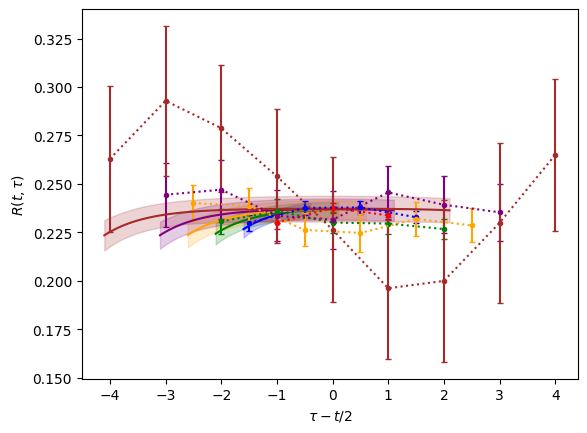

In [25]:
COLORS = ["red","blue","green", "orange", "purple", "brown", "pink", "black"]

_=plt.figure()

for iT, T in enumerate(Tlist):

    norm_K = Klist[iop].mean
    taus = np.arange(1,T)

    _=plt.errorbar(
        taus - T/2,
        np.mean( Ratios_resamples[T][:,1:-1], axis = 0 )/norm_K,
        np.std ( Ratios_resamples[T][:,1:-1], axis = 0 )/np.abs(norm_K),
        fmt = '.:',
        capsize = 2,
        label = f"${T=}$",
        color = COLORS[iT]
    )

    if cut_dict[T] is not None:

        eps=0.1
        cont_taus = np.linspace(cut_dict[T][0]-eps, cut_dict[T][1]-1+eps,100)

        abscissa = np.array([
            (T, tau) for tau in cont_taus
        ])

        fit_ordinate = fit_result.eval( abscissa )

        _=plt.plot(cont_taus-T/2, fit_ordinate["est"] / norm_K, color = COLORS[iT])
        
        _=plt.fill_between(
            cont_taus-T/2, 
            (fit_ordinate["est"]+fit_ordinate["err"]) / norm_K,
            (fit_ordinate["est"]-fit_ordinate["err"]) / norm_K,
            color = COLORS[iT],
            alpha = 0.2
        )

_=plt.xlabel(r"$\tau - t/2$")
_=plt.ylabel(r"$R(t,\tau)$")
_=plt.show()

In [26]:
num = 8
int(num/2)
int(num/2)+1 + num%2

4

5

In [27]:
#opAnalyzer.get_E(force_fit=True)

## Number of Points Increase

In [28]:
def abscissa_ratio_from_cutdict(cutdict):
    abscissa = np.array([
        [T, tau] for T in Tlist if cutdict[T] is not None for tau in np.arange(0,T+1)[cutdict[T][0]:cutdict[T][1]] 
    ])

    Ratio_ror = np.zeros( (Nbst, len(abscissa)) )

    for idx, (t,tau) in enumerate(abscissa):

        Ratio_ror[:,idx] = Ratios_resamples[t][:,tau]

    return abscissa, Ratio_ror

In [29]:
from copy import deepcopy

In [30]:
#cut_dict_old = { k:v for k,v in cut_dict.items()}
#N_points_dict_old = { k:v for k,v in N_points_dict.items()}

cut_dict_old = deepcopy(cut_dict)
N_points_dict_old = deepcopy(N_points_dict)

In [31]:
#we instanatiate the states of the fits we want to do
fit_state = CA.FitState()

for mix_term in [False,True]:

    model = SymmetricRatioModel(number_states_sink=2,number_states_source=2, include_mix_term = mix_term)

    flat_prior = model.flat_prior(sign=1 if mat_ele_avg.mean>0 else -1,dE_mean=dE.mean)

    abscissa, Ratio_ror = abscissa_ratio_from_cutdict(cut_dict)

    #first fit 
    #............
    fit_result = CA.fit(
                        abscissa = abscissa,
                        ordinate_est = np.mean( Ratio_ror, axis = 0 ),
                        ordinate_std = np.std ( Ratio_ror, axis = 0 ),
                        ordinate_cov = np.cov ( Ratio_ror, rowvar = False ),
                        resample_ordinate_est = Ratio_ror,
                        resample_ordinate_std = np.std ( Ratio_ror, axis = 0 ),
                        resample_ordinate_cov = np.cov ( Ratio_ror, rowvar = False ),
                        
                        central_value_fit = True,
                        central_value_fit_correlated = True,
                        resample_fit = True,
                        resample_fit_correlated = True,
                        resample_fit_resample_prior = False,
                        resample_type = "bst",
                        # Fitting infos
                        model = model,
                        #prior = model_prior,
                        prior=flat_prior,
                        #prior=guess_prior,
                        )
    fit_state.append(fit_result)

    cut_dict = deepcopy(cut_dict_old)
    N_points_dict = deepcopy(N_points_dict_old)
    print(cut_dict_old)

    while True:
        
        fit_done=False

        currentT_list = list(cut_dict.keys())
        cut_list = list(cut_dict.values())
        Npoints_list = list(N_points_dict.values())

        for i, (T, cuts, Npoints) in enumerate(zip(currentT_list,cut_list,Npoints_list)):
            #i,T,cuts,Npoints

            if i==0 and Npoints!=0: continue

            if (i==0 and Npoints==0) or (Npoints < list(N_points_dict.values())[i-1] and Npoints <T):
                
                if Npoints!=0:
                    cut_dict[T] = (cut_dict[T][0]-1,cut_dict[T][1]+1)
                    N_points_dict[T] += 2
                else:
                    cut_dict[T] = (int(T/2), int(T/2)+1 + T%2)
                    N_points_dict[T] += 1 + T%2

                #do other fit.......
                abscissa, Ratio_ror = abscissa_ratio_from_cutdict(cut_dict)

                fit_result = CA.fit(
                                    abscissa = abscissa,
                                    ordinate_est = np.mean( Ratio_ror, axis = 0 ),
                                    ordinate_std = np.std ( Ratio_ror, axis = 0 ),
                                    ordinate_cov = np.cov ( Ratio_ror, rowvar = False ),
                                    resample_ordinate_est = Ratio_ror,
                                    resample_ordinate_std = np.std ( Ratio_ror, axis = 0 ),
                                    resample_ordinate_cov = np.cov ( Ratio_ror, rowvar = False ),
                                    
                                    central_value_fit = True,
                                    central_value_fit_correlated = True,
                                    resample_fit = True,
                                    resample_fit_correlated = True,
                                    resample_fit_resample_prior = False,
                                    resample_type = "bst",
                                    # Fitting infos
                                    model = model,
                                    #prior = model_prior,
                                    prior=flat_prior,
                                    #prior=guess_prior,
                                    )
                fit_state.append(fit_result)
                fit_done = True

        if fit_done==False: break

{4: None, 5: (1, 3), 6: (1, 4), 7: (1, 5), 8: (1, 6), 10: (1, 8)}
{4: None, 5: (1, 3), 6: (1, 4), 7: (1, 5), 8: (1, 6), 10: (1, 8)}


In [32]:
cut_dict

{4: (2, 3), 5: (1, 3), 6: (1, 4), 7: (1, 5), 8: (1, 6), 10: (1, 8)}

In [33]:
fit_state

FitState(fit_results=[FitResult[ ([5 1],[10  7]), resample:bst]:
  𝜒²/dof [dof] = 1.25 [21]
  AIC = -8.3 
    - A00: 0.051(53)  [1(100)]
    - dE1(0): 4.7(3.0)  [0.3(2.7)]
    - A01: -1.2(1.2)  [1(100)]
, FitResult[ ([4 2],[10  7]), resample:bst]:
  𝜒²/dof [dof] = 1.2 [22]
  AIC = -7.34 
    - A00: -0.03(55)  [1(100)]
    - dE1(0): 4.0(2.1)  [0.3(2.7)]
    - A01: -0.6(1.2)  [1(100)]
    - A11: 7(17)  [1(100)]
, FitResult[ ([4 2],[10  7]), resample:bst]:
  𝜒²/dof [dof] = 1.2 [22]
  AIC = -7.34 
    - A00: -0.03(55)  [1(100)]
    - dE1(0): 4.0(2.1)  [0.3(2.7)]
    - A01: -0.6(1.2)  [1(100)]
    - A11: 7(17)  [1(100)]
, FitResult[ ([4 2],[10  7]), resample:bst]:
  𝜒²/dof [dof] = 1.91 [22]
  AIC = 5.41 
    - A00: 0.033(19)  [1(100)]
    - dE1(0): 1.7(2.7)  [0.3(2.7)]
    - A01: -0.32(83)  [1(100)]
], keys_all=['A00', 'dE1(0)', 'A01', 'A11'], param_avg={})

In [34]:
def weights_from_fitstate(fitstate):
    AIC_array =np.array( [fitres.AIC for fitres in fitstate] )
    AIC_min = np.min(AIC_array)
    weights = np.exp(-0.5 * (AIC_array - AIC_min)) 
    return weights/np.sum(weights)

In [35]:
result_dict = {parm:gv.gvar(fit_state.model_average()["est"][parm], fit_state.model_average()["err"][parm]) for parm in fit_state.model_average()["est"] }

result_dict

result_dict["A00"] / Klist[iop]

opAnalyzer.lattice_to_MeV(result_dict['dE1(0)'])

{'A00': 0.004(62), 'dE1(0)': 4.3(1.9), 'A01': -0.8(1.1), 'A11': 7(17)}

0.03(37)

7.4(3.3)e+03

In [36]:
weights_from_fitstate(fit_state)

array([0.44719473, 0.27616684, 0.27616684, 0.00047158])

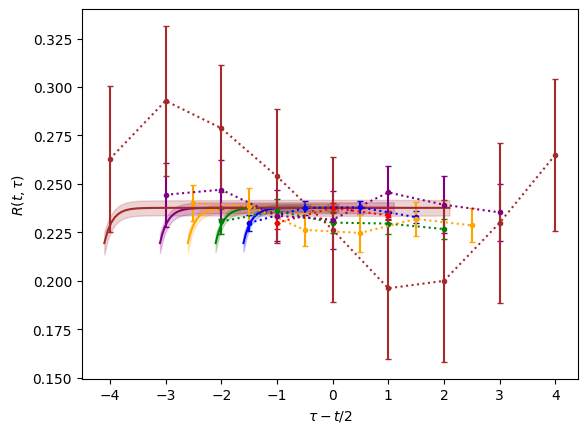

In [37]:
COLORS = ["red","blue","green", "orange", "purple", "brown", "pink", "black"]

_=plt.figure()

for iT, T in enumerate(Tlist):

    norm_K = Klist[iop].mean
    taus = np.arange(1,T)

    _=plt.errorbar(
        taus - T/2,
        np.mean( Ratios_resamples[T][:,1:-1], axis = 0 )/norm_K,
        np.std ( Ratios_resamples[T][:,1:-1], axis = 0 )/np.abs(norm_K),
        fmt = '.:',
        capsize = 2,
        label = f"${T=}$",
        color = COLORS[iT]
    )

    if cut_dict[T] is not None:

        eps=0.1
        cont_taus = np.linspace(cut_dict[T][0]-eps, cut_dict[T][1]-1+eps,100)

        abscissa = np.array([
            (T, tau) for tau in cont_taus
        ])

        fit_ordinate_array = np.array( [ gv.gvar( fitresult.eval( abscissa )["est"], fitresult.eval( abscissa )["err"] ) for fitresult in fit_state] )
        fit_ordinate = np.average(fit_ordinate_array, axis=0, weights=weights_from_fitstate(fit_state))

        ordinate_mean = np.array( [ordinate.mean for ordinate in fit_ordinate] )
        ordinate_high = np.array( [ordinate.mean + ordinate.sdev for ordinate in fit_ordinate] )
        ordinate_low = np.array( [ordinate.mean - ordinate.sdev for ordinate in fit_ordinate] )

        _=plt.plot(cont_taus-T/2, ordinate_mean / norm_K, color = COLORS[iT])
        
        _=plt.fill_between(
            cont_taus-T/2, 
            ordinate_high / norm_K,
            ordinate_low / norm_K,
            color = COLORS[iT],
            alpha = 0.2
        )

_=plt.xlabel(r"$\tau - t/2$")
_=plt.ylabel(r"$R(t,\tau)$")
_=plt.show()

# Generic Method

In [38]:
opAnalyzer.display_operators()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [39]:
#opAnalyzer.set_resampling_type("bootstrap")
opAnalyzer.set_resampling_type("jackknife")
opAnalyzer.set_fit_parms(central_value_fit=True, central_value_fit_correlated=True, resample_fit=True, resample_fit_correlated=True)
#opAnalyzer.set_fit_parms(central_value_fit=True, central_value_fit_correlated=True, resample_fit=False, resample_fit_correlated=False)
opAnalyzer.remove_T(12)

In [40]:
opAnalyzer

Instance of the moments_toolkit class

Dataset Specifics:
Number of configurations: 212
P: [-2  0  0]
q: [0 0 0]

Current Selection of Parameters:
Number of Selected Operators: 9
Selected Isospin: U-D
Selected T values: [3, 4, 5, 6, 7, 8, 10]

Fit parameters:
 - Central Value Fit:            True
 - Central Value Fit Correlated: True
 - Resample Fit:                 True
 - Resample Fit Correlated:      True
 - Resample Fit Resample Prior:  False
 - SVD Cut: None
 - Max Iterations: 10000

Resampling Technique: jackknife


Preparing the fit for the ratio of the correlators...


Looping over the operators, performing for each a series of fit: ...



100%|██████████| 9/9 [00:47<00:00,  5.32s/it]



Plotting the fit of the ratios for each operator ...



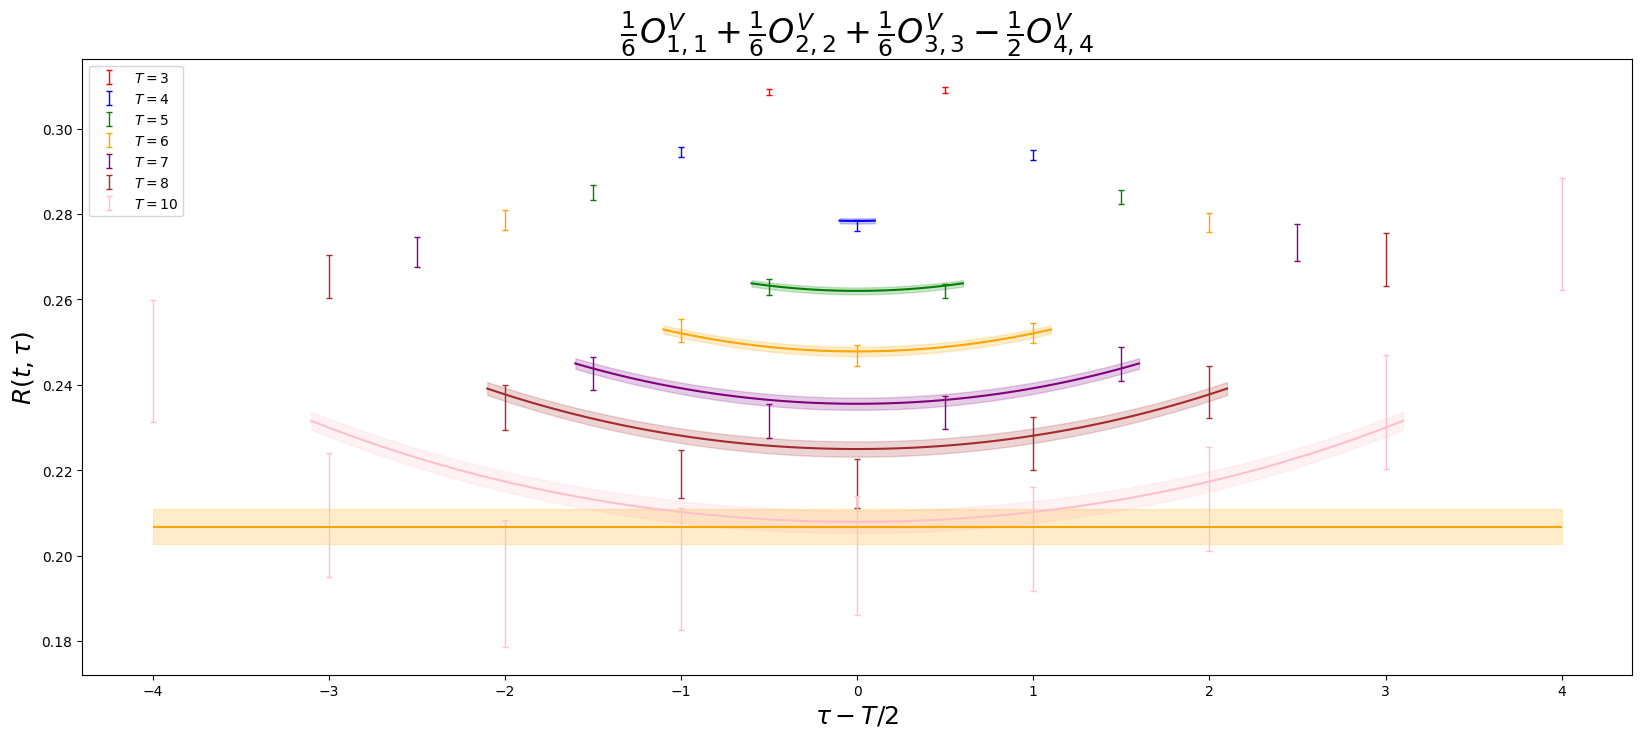

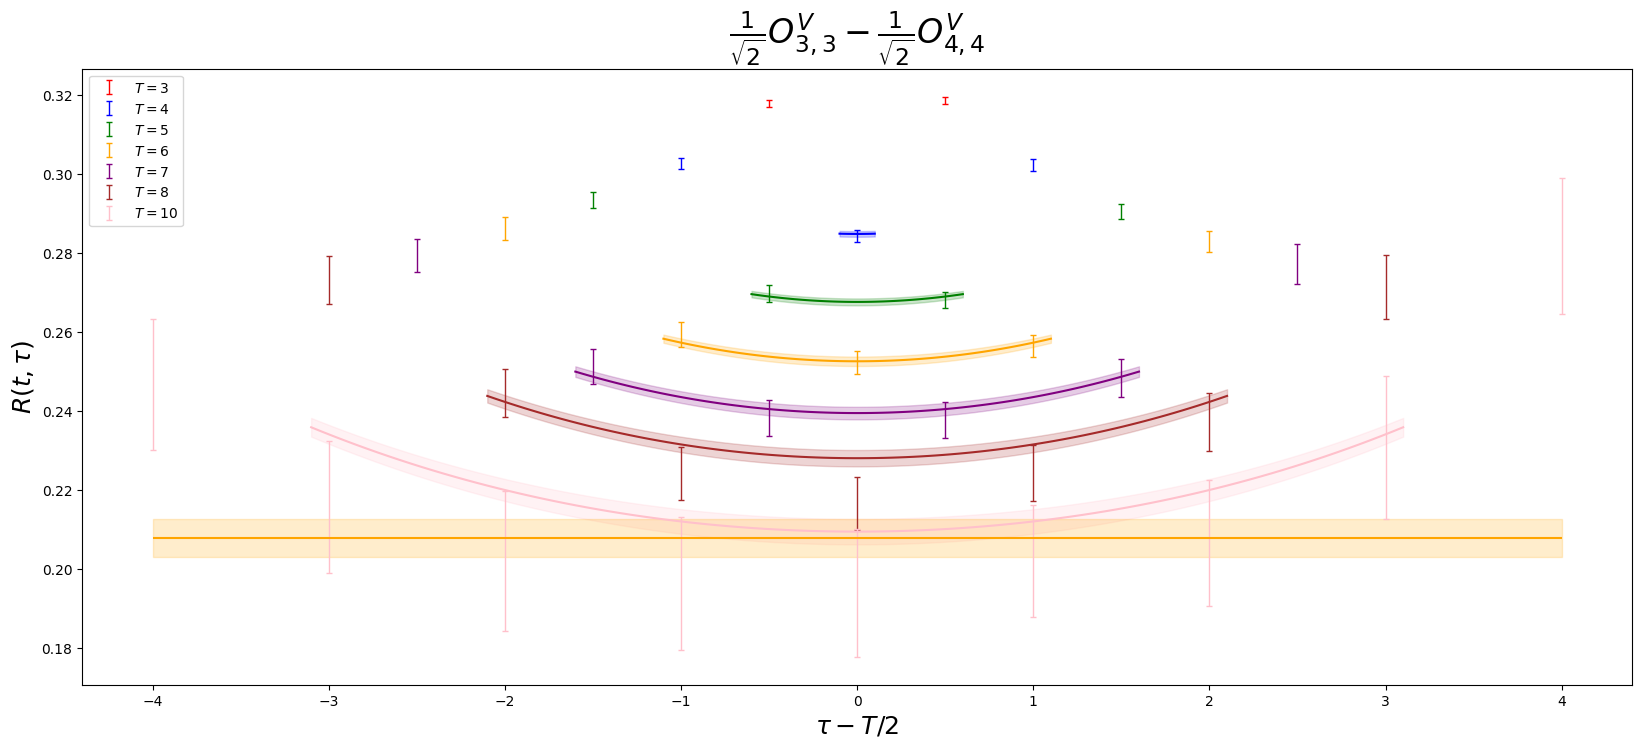

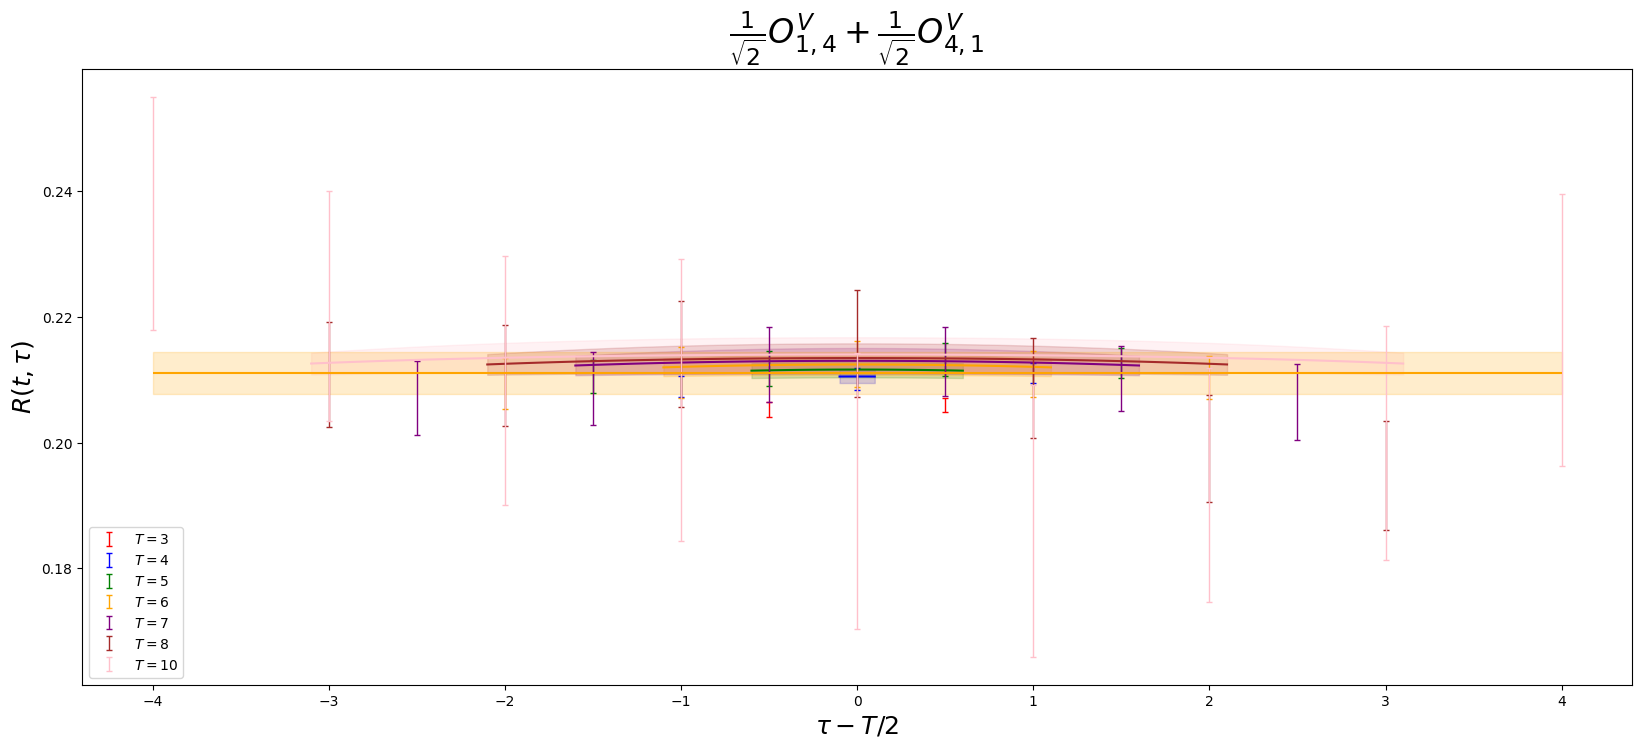

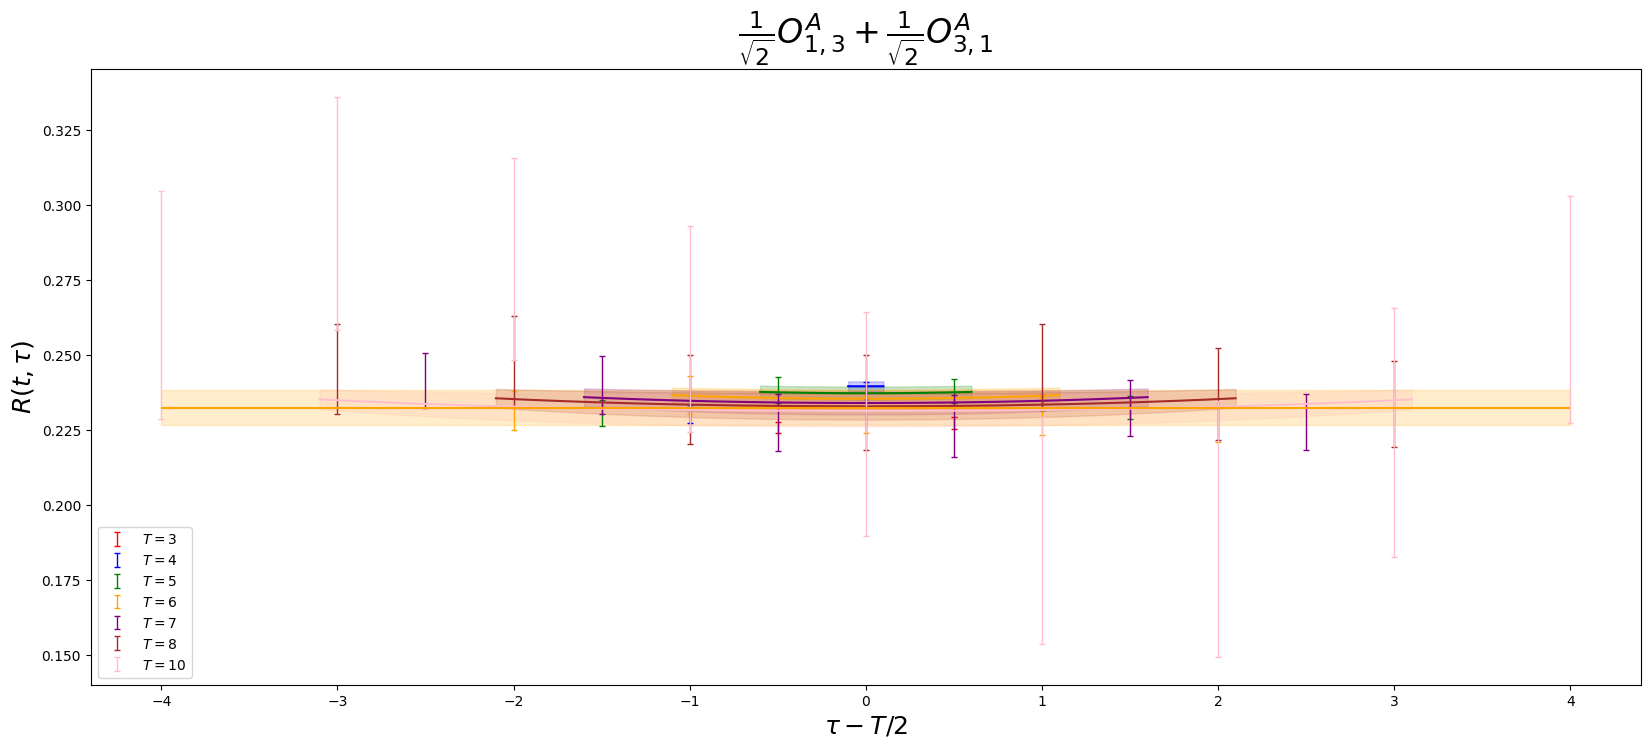

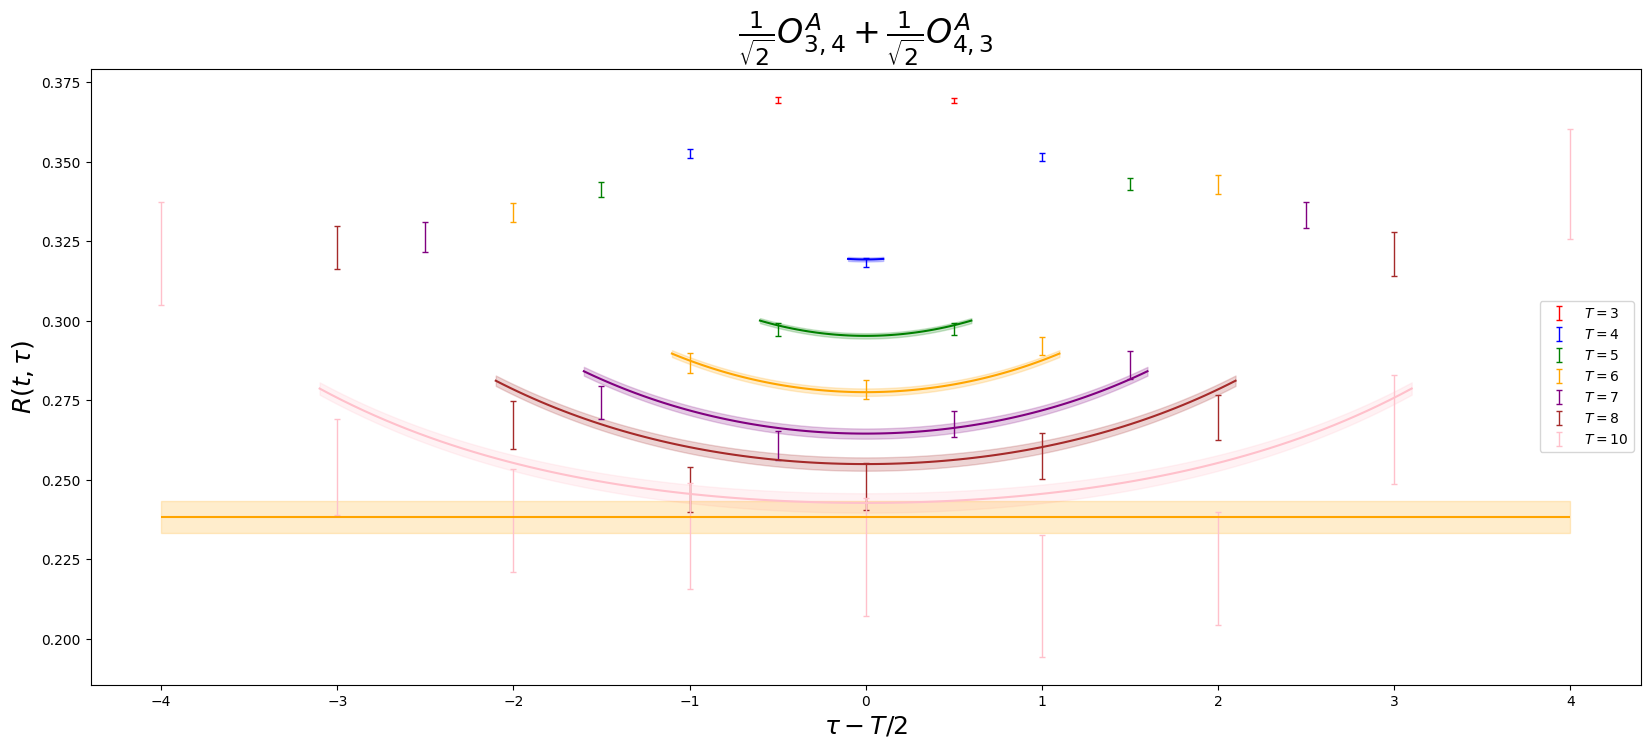

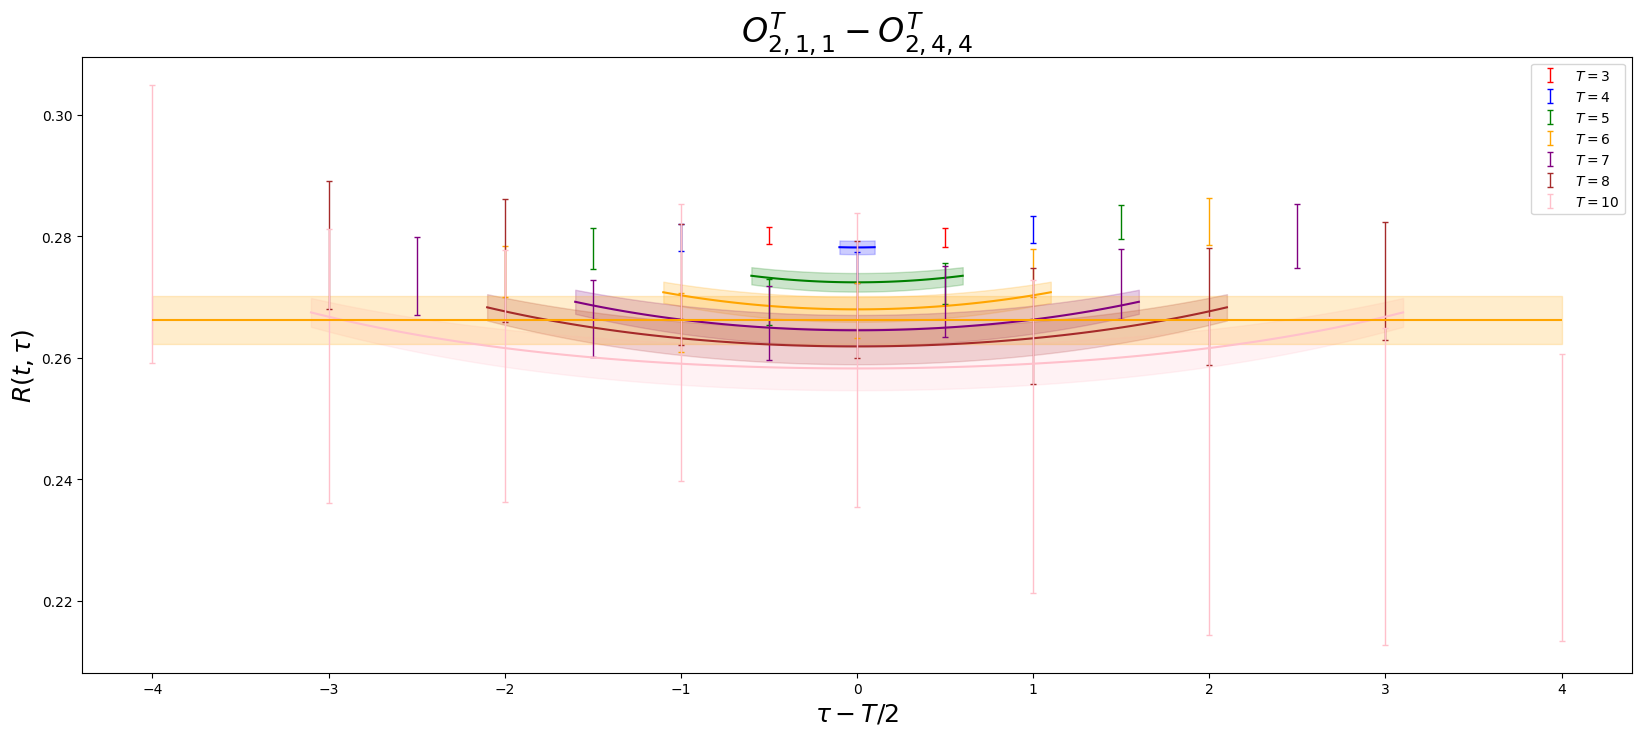

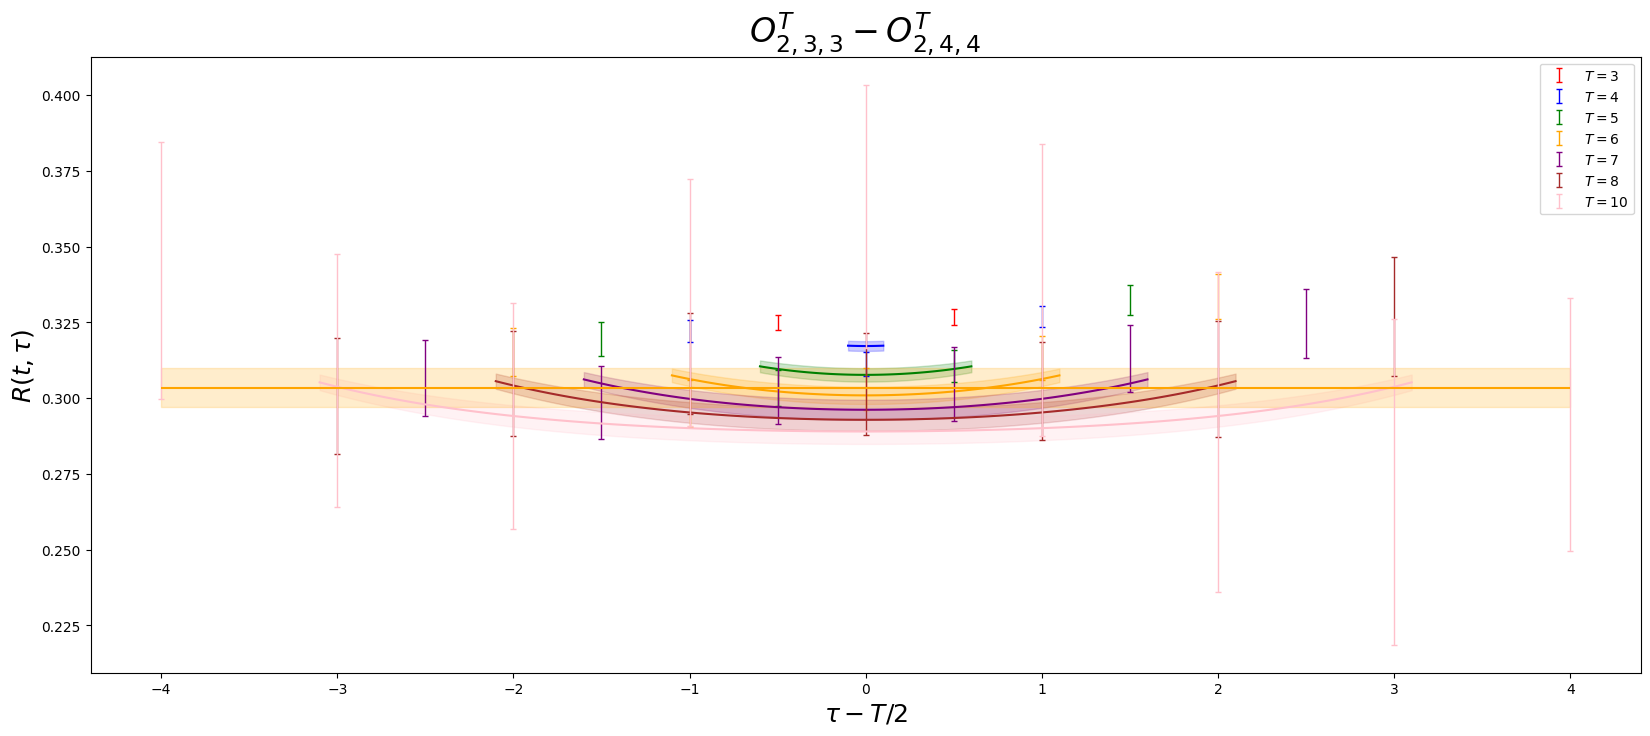

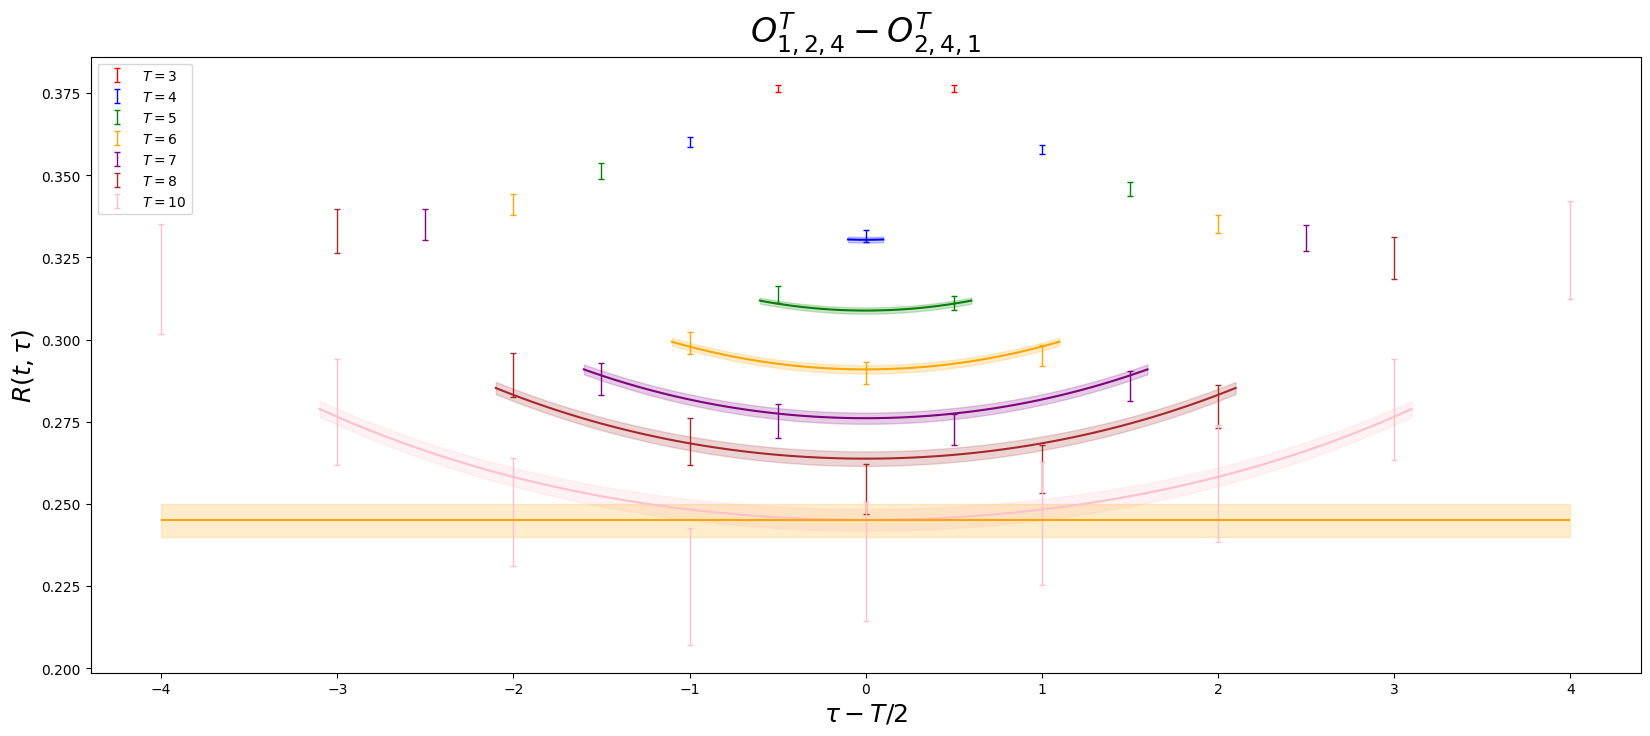

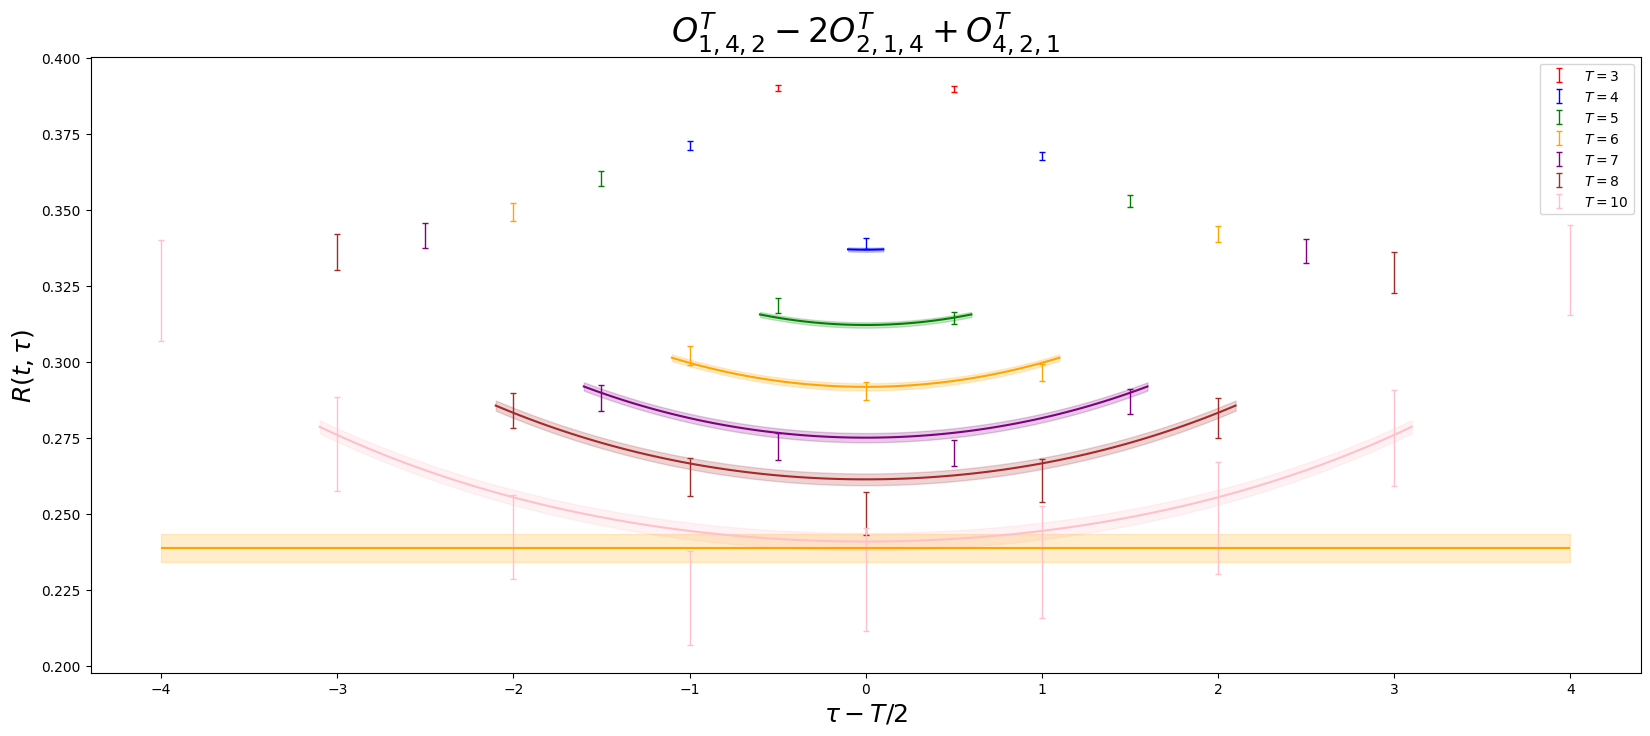


Fit routine succesfully completed!



In [41]:
fit_res = opAnalyzer.fit_ratio(verbose=True, show=True,save=True, prior="guess")

In [42]:
opAnalyzer.get_M_from_S(method="finite differences",moments=True)

array([[0 ± 0, 0.2367(29), 0.2147(54), 0.2047(75), 0.182(13), 0.174(21),
        0 ± 0],
       [0 ± 0, 0.2419(35), 0.2173(65), 0.2067(86), 0.173(15), 0.169(25),
        0 ± 0],
       [0 ± 0, 0.2128(42), 0.2089(74), 0.211(10), 0.199(20), 0.181(36),
        0 ± 0],
       [0 ± 0, 0.2322(72), 0.229(13), 0.237(18), 0.254(39), 0.225(62),
        0 ± 0],
       [0 ± 0, 0.2676(34), 0.2470(63), 0.2335(93), 0.203(18), 0.194(28),
        0 ± 0],
       [0 ± 0, 0.2665(48), 0.2674(90), 0.269(12), 0.256(24), 0.229(41),
        0 ± 0],
       [0 ± 0, 0.3022(78), 0.303(15), 0.306(22), 0.320(40), 0.345(74),
        0 ± 0],
       [0 ± 0, 0.2777(39), 0.2501(67), 0.2443(90), 0.225(17), 0.213(29),
        0 ± 0],
       [0 ± 0, 0.2763(34), 0.2446(61), 0.2367(85), 0.216(17), 0.204(28),
        0 ± 0]], dtype=object)

In [43]:
for iop,res in enumerate(fit_res):
    result = res.model_average()
    mat = gv.gvar( result["est"]["A00"], result["err"]["A00"] )
    mat / Klist[iop]
    [fit.chi2/fit.dof for fit in res]
    #[fit.chi2_res/fit.dof for fit in res]
    

0.1585(13)

[0.8282874687473765,
 0.8547204319849578,
 0.7867270521238354,
 0.7867270521238354]

0.1525(22)

[1.138495386708385, 1.043900878055193, 1.043900878055193, 1.1415065987037596]

0.21473(39)

[0.9694975038317518,
 0.9609332508737511,
 0.9667497862065215,
 0.9667497862065215]

0.22914(78)

[1.1172391003013116, 1.1148397804518915, 1.110794606051481, 1.110794606051481]

0.22834(80)

[1.4255373139097827,
 1.4686010361048916,
 1.4031475669670843,
 1.4031475669670843,
 1.545681709726085,
 1.4160227691454672]

0.25301(56)

[0.757523410165753, 0.7935301992744699, 0.7403602972396935, 0.7403602972396935]

0.28550(62)

[1.0118344281712524,
 1.0027360174845021,
 0.9334474169783832,
 0.9334474169783832]

0.2052(14)

[0.9605014148867299,
 1.0319927336500259,
 0.9307613384220107,
 0.9307613384220107]

0.1995(12)

[1.0023628322477889,
 0.9517612161814601,
 0.9517612161814601,
 1.0360248412195339,
 1.0047504907851,
 0.9588544080065111]

In [44]:
mat_ele_R = opAnalyzer.get_M_from_R()
mat_ele_R
moments_R = opAnalyzer.get_M_from_R(moments=True)
moments_R

array([0.05213(43), 0.06698(97), -0.07950(14), 0.03847(13), -0.09094(31),
       -0.13248(29), -0.07474(16), 0.1501(10), 0.2698(16)], dtype=object)

array([0.1585(13), 0.1525(22), 0.21473(39), 0.22914(78), 0.22834(80),
       0.25301(56), 0.28550(62), 0.2052(14), 0.1995(12)], dtype=object)

In [45]:
Zlist = opAnalyzer.get_Zlist()
Zlist

moments_R * Zlist

[0.976(23),
 0.976(23),
 0.999(24),
 0.995(31),
 0.995(31),
 0.992(23),
 0.992(23),
 0.995(24),
 0.995(24)]

array([0.1547(38), 0.1489(41), 0.2145(52), 0.2281(73), 0.2273(72),
       0.2509(59), 0.2832(67), 0.2042(51), 0.1985(49)], dtype=object)

In [46]:
#opAnalyzer.set_resampling_type("bootstrap")
opAnalyzer.set_resampling_type("jackknife")
opAnalyzer.set_fit_parms(central_value_fit=True, central_value_fit_correlated=True, resample_fit=True, resample_fit_correlated=True)
#opAnalyzer.set_fit_parms(central_value_fit=True, central_value_fit_correlated=True, resample_fit=False, resample_fit_correlated=False)
opAnalyzer.remove_T(12)

opAnalyzer.get_M_from_R(moments=True, renormalize=False)
opAnalyzer.get_M_from_R(moments=True, renormalize=True)

""

opAnalyzer.get_M_from_S(method="fit", moments=True, renormalize=False)
opAnalyzer.get_M_from_S(method="fit", moments=True, renormalize=True)

""

opAnalyzer.get_M_from_S(method="finite differences", moments=True, renormalize=False)
opAnalyzer.get_M_from_S(method="finite differences", moments=True, renormalize=True)

array([0.1585(13), 0.1525(22), 0.21473(39), 0.22914(78), 0.22834(80),
       0.25301(56), 0.28550(62), 0.2052(14), 0.1995(12)], dtype=object)

array([0.1547(38), 0.1489(41), 0.2145(52), 0.2281(73), 0.2273(72),
       0.2509(59), 0.2832(67), 0.2042(51), 0.1985(49)], dtype=object)

''

array([[0 ± 0, 0.2382(22), 0.2117(34), 0.1943(62), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2434(26), 0.2141(41), 0.1931(76), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2120(26), 0.2078(60), 0.2071(74), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2335(45), 0.229(11), 0.238(13), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2682(22), 0.2448(45), 0.2220(81), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2663(32), 0.2653(73), 0.2643(82), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.3027(52), 0.304(12), 0.309(14), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2767(20), 0.2471(53), 0.2367(78), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2766(26), 0.2416(48), 0.2275(76), 0 ± 0, 0 ± 0, 0 ± 0]],
      dtype=object)

array([[0 ± 0, 0.2326(58), 0.2067(59), 0.1897(75), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2376(61), 0.2090(63), 0.1886(86), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2118(58), 0.2076(78), 0.2069(90), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2324(86), 0.228(13), 0.237(15), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2670(87), 0.2436(89), 0.221(11), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2641(69), 0.2631(95), 0.262(10), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.3002(87), 0.301(14), 0.306(16), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2754(69), 0.2459(79), 0.2356(96), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2752(71), 0.2405(75), 0.2264(93), 0 ± 0, 0 ± 0, 0 ± 0]],
      dtype=object)

''

array([[0 ± 0, 0.2367(29), 0.2147(54), 0.2047(75), 0.182(13), 0.174(21),
        0 ± 0],
       [0 ± 0, 0.2419(35), 0.2173(65), 0.2067(86), 0.173(15), 0.169(25),
        0 ± 0],
       [0 ± 0, 0.2128(42), 0.2089(74), 0.211(10), 0.199(20), 0.181(36),
        0 ± 0],
       [0 ± 0, 0.2322(72), 0.229(13), 0.237(18), 0.254(39), 0.225(62),
        0 ± 0],
       [0 ± 0, 0.2676(34), 0.2470(63), 0.2335(93), 0.203(18), 0.194(28),
        0 ± 0],
       [0 ± 0, 0.2665(48), 0.2674(90), 0.269(12), 0.256(24), 0.229(41),
        0 ± 0],
       [0 ± 0, 0.3022(78), 0.303(15), 0.306(22), 0.320(40), 0.345(74),
        0 ± 0],
       [0 ± 0, 0.2777(39), 0.2501(67), 0.2443(90), 0.225(17), 0.213(29),
        0 ± 0],
       [0 ± 0, 0.2763(34), 0.2446(61), 0.2367(85), 0.216(17), 0.204(28),
        0 ± 0]], dtype=object)

array([[0 ± 0, 0.2311(61), 0.2096(72), 0.1999(87), 0.177(13), 0.170(20),
        0 ± 0],
       [0 ± 0, 0.2361(65), 0.2121(80), 0.2018(96), 0.169(15), 0.165(25),
        0 ± 0],
       [0 ± 0, 0.2126(66), 0.2087(90), 0.210(11), 0.198(20), 0.181(36),
        0 ± 0],
       [0 ± 0, 0.231(10), 0.228(15), 0.236(20), 0.253(40), 0.224(62),
        0 ± 0],
       [0 ± 0, 0.2664(91), 0.246(10), 0.232(12), 0.202(19), 0.193(29),
        0 ± 0],
       [0 ± 0, 0.2643(78), 0.265(11), 0.267(14), 0.254(25), 0.227(41),
        0 ± 0],
       [0 ± 0, 0.300(10), 0.300(17), 0.303(23), 0.317(40), 0.343(74),
        0 ± 0],
       [0 ± 0, 0.2764(77), 0.2489(89), 0.243(11), 0.224(18), 0.212(30),
        0 ± 0],
       [0 ± 0, 0.2750(74), 0.2435(84), 0.236(10), 0.215(17), 0.203(28),
        0 ± 0]], dtype=object)

In [47]:
opAnalyzer.set_resampling_type("bootstrap", Nres=1000)
#opAnalyzer.set_resampling_type("jackknife")
opAnalyzer.set_fit_parms(central_value_fit=True, central_value_fit_correlated=True, resample_fit=True, resample_fit_correlated=True)
#opAnalyzer.set_fit_parms(central_value_fit=True, central_value_fit_correlated=True, resample_fit=False, resample_fit_correlated=False)
opAnalyzer.remove_T(12)


opAnalyzer.get_M_from_R(moments=True, renormalize=False)
opAnalyzer.get_M_from_R(moments=True, renormalize=True)

""

opAnalyzer.get_M_from_S(method="fit", moments=True, renormalize=False)
opAnalyzer.get_M_from_S(method="fit", moments=True, renormalize=True)

""

opAnalyzer.get_M_from_S(method="finite differences", moments=True, renormalize=False)
opAnalyzer.get_M_from_S(method="finite differences", moments=True, renormalize=True)

array([0.154(28), 0.140(42), 0.2143(83), 0.230(15), 0.223(24), 0.251(11),
       0.283(11), 0.200(23), 0.199(19)], dtype=object)

array([0.151(28), 0.137(42), 0.2140(98), 0.229(17), 0.222(25), 0.249(12),
       0.281(12), 0.199(23), 0.198(20)], dtype=object)

''

array([[0 ± 0, 0.2381(28), 0.2122(38), 0.1955(63), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2437(33), 0.2147(45), 0.1945(77), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2122(26), 0.2081(61), 0.2078(75), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2337(46), 0.229(11), 0.238(13), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2689(36), 0.2453(53), 0.2227(86), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2662(31), 0.2654(73), 0.2645(82), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.3028(52), 0.304(12), 0.310(14), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2775(26), 0.2477(56), 0.2376(80), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2774(33), 0.2419(51), 0.2281(78), 0 ± 0, 0 ± 0, 0 ± 0]],
      dtype=object)

array([[0 ± 0, 0.2325(61), 0.2072(61), 0.1909(76), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2379(64), 0.2096(66), 0.1899(87), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2120(58), 0.2079(79), 0.2076(90), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2326(87), 0.228(13), 0.237(15), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2676(92), 0.2442(93), 0.222(11), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2641(69), 0.2632(95), 0.262(10), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.3003(87), 0.302(14), 0.307(16), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2761(71), 0.2465(81), 0.2365(98), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2761(74), 0.2408(77), 0.2270(95), 0 ± 0, 0 ± 0, 0 ± 0]],
      dtype=object)

''

array([[0 ± 0, 0.2368(33), 0.2150(56), 0.2053(76), 0.183(13), 0.175(21),
        0 ± 0],
       [0 ± 0, 0.2421(40), 0.2177(68), 0.2073(87), 0.174(15), 0.170(25),
        0 ± 0],
       [0 ± 0, 0.2129(42), 0.2090(76), 0.211(10), 0.200(20), 0.183(35),
        0 ± 0],
       [0 ± 0, 0.2323(74), 0.229(13), 0.237(19), 0.253(39), 0.222(63),
        0 ± 0],
       [0 ± 0, 0.2680(44), 0.2476(70), 0.2340(97), 0.204(19), 0.195(29),
        0 ± 0],
       [0 ± 0, 0.2664(48), 0.2676(92), 0.269(13), 0.256(25), 0.229(40),
        0 ± 0],
       [0 ± 0, 0.3022(78), 0.303(15), 0.307(21), 0.322(40), 0.348(76),
        0 ± 0],
       [0 ± 0, 0.2780(43), 0.2504(70), 0.2450(94), 0.226(18), 0.213(30),
        0 ± 0],
       [0 ± 0, 0.2765(41), 0.2449(65), 0.2373(89), 0.217(17), 0.204(28),
        0 ± 0]], dtype=object)

array([[0 ± 0, 0.2312(63), 0.2099(74), 0.2004(88), 0.179(13), 0.171(21),
        0 ± 0],
       [0 ± 0, 0.2363(68), 0.2125(83), 0.2024(97), 0.170(15), 0.166(25),
        0 ± 0],
       [0 ± 0, 0.2127(67), 0.2088(91), 0.211(11), 0.200(20), 0.183(36),
        0 ± 0],
       [0 ± 0, 0.231(10), 0.228(15), 0.236(20), 0.251(40), 0.221(63),
        0 ± 0],
       [0 ± 0, 0.2668(95), 0.246(10), 0.233(12), 0.203(20), 0.194(29),
        0 ± 0],
       [0 ± 0, 0.2642(78), 0.265(11), 0.267(14), 0.254(25), 0.227(40),
        0 ± 0],
       [0 ± 0, 0.300(10), 0.301(17), 0.304(22), 0.319(41), 0.345(76),
        0 ± 0],
       [0 ± 0, 0.2766(79), 0.2492(92), 0.244(11), 0.225(18), 0.212(30),
        0 ± 0],
       [0 ± 0, 0.2751(77), 0.2437(87), 0.236(10), 0.216(18), 0.203(28),
        0 ± 0]], dtype=object)

In [48]:
#opAnalyzer.set_resampling_type("bootstrap")
opAnalyzer.set_resampling_type("jackknife")
opAnalyzer.set_fit_parms(central_value_fit=True, central_value_fit_correlated=True, resample_fit=True, resample_fit_correlated=True)
#opAnalyzer.set_fit_parms(central_value_fit=True, central_value_fit_correlated=True, resample_fit=False, resample_fit_correlated=False)
opAnalyzer.remove_T(12)

opAnalyzer.get_M_from_R(moments=True, renormalize=False)
opAnalyzer.get_M_from_R(moments=True, renormalize=True)

""

opAnalyzer.get_M_from_S(method="fit", moments=True, renormalize=False)
opAnalyzer.get_M_from_S(method="fit", moments=True, renormalize=True)

""

opAnalyzer.get_M_from_S(method="finite differences", moments=True, renormalize=False)
opAnalyzer.get_M_from_S(method="finite differences", moments=True, renormalize=True)

array([0.1585(13), 0.1525(22), 0.21473(39), 0.22914(78), 0.22834(80),
       0.25301(56), 0.28550(62), 0.2052(14), 0.1995(12)], dtype=object)

array([0.1547(38), 0.1489(41), 0.2145(52), 0.2281(73), 0.2273(72),
       0.2509(59), 0.2832(67), 0.2042(51), 0.1985(49)], dtype=object)

''

array([[0 ± 0, 0.2382(22), 0.2117(34), 0.1943(62), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2434(26), 0.2141(41), 0.1931(76), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2120(26), 0.2078(60), 0.2071(74), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2335(45), 0.229(11), 0.238(13), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2682(22), 0.2448(45), 0.2220(81), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2663(32), 0.2653(73), 0.2643(82), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.3027(52), 0.304(12), 0.309(14), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2767(20), 0.2471(53), 0.2367(78), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2766(26), 0.2416(48), 0.2275(76), 0 ± 0, 0 ± 0, 0 ± 0]],
      dtype=object)

array([[0 ± 0, 0.2326(58), 0.2067(59), 0.1897(75), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2376(61), 0.2090(63), 0.1886(86), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2118(58), 0.2076(78), 0.2069(90), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2324(86), 0.228(13), 0.237(15), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2670(87), 0.2436(89), 0.221(11), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2641(69), 0.2631(95), 0.262(10), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.3002(87), 0.301(14), 0.306(16), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2754(69), 0.2459(79), 0.2356(96), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2752(71), 0.2405(75), 0.2264(93), 0 ± 0, 0 ± 0, 0 ± 0]],
      dtype=object)

''

array([[0 ± 0, 0.2367(29), 0.2147(54), 0.2047(75), 0.182(13), 0.174(21),
        0 ± 0],
       [0 ± 0, 0.2419(35), 0.2173(65), 0.2067(86), 0.173(15), 0.169(25),
        0 ± 0],
       [0 ± 0, 0.2128(42), 0.2089(74), 0.211(10), 0.199(20), 0.181(36),
        0 ± 0],
       [0 ± 0, 0.2322(72), 0.229(13), 0.237(18), 0.254(39), 0.225(62),
        0 ± 0],
       [0 ± 0, 0.2676(34), 0.2470(63), 0.2335(93), 0.203(18), 0.194(28),
        0 ± 0],
       [0 ± 0, 0.2665(48), 0.2674(90), 0.269(12), 0.256(24), 0.229(41),
        0 ± 0],
       [0 ± 0, 0.3022(78), 0.303(15), 0.306(22), 0.320(40), 0.345(74),
        0 ± 0],
       [0 ± 0, 0.2777(39), 0.2501(67), 0.2443(90), 0.225(17), 0.213(29),
        0 ± 0],
       [0 ± 0, 0.2763(34), 0.2446(61), 0.2367(85), 0.216(17), 0.204(28),
        0 ± 0]], dtype=object)

array([[0 ± 0, 0.2311(61), 0.2096(72), 0.1999(87), 0.177(13), 0.170(20),
        0 ± 0],
       [0 ± 0, 0.2361(65), 0.2121(80), 0.2018(96), 0.169(15), 0.165(25),
        0 ± 0],
       [0 ± 0, 0.2126(66), 0.2087(90), 0.210(11), 0.198(20), 0.181(36),
        0 ± 0],
       [0 ± 0, 0.231(10), 0.228(15), 0.236(20), 0.253(40), 0.224(62),
        0 ± 0],
       [0 ± 0, 0.2664(91), 0.246(10), 0.232(12), 0.202(19), 0.193(29),
        0 ± 0],
       [0 ± 0, 0.2643(78), 0.265(11), 0.267(14), 0.254(25), 0.227(41),
        0 ± 0],
       [0 ± 0, 0.300(10), 0.300(17), 0.303(23), 0.317(40), 0.343(74),
        0 ± 0],
       [0 ± 0, 0.2764(77), 0.2489(89), 0.243(11), 0.224(18), 0.212(30),
        0 ± 0],
       [0 ± 0, 0.2750(74), 0.2435(84), 0.236(10), 0.215(17), 0.203(28),
        0 ± 0]], dtype=object)

In [49]:
opAnalyzer.set_resampling_type("bootstrap", Nres=1000)
#opAnalyzer.set_resampling_type("jackknife")
#opAnalyzer.set_fit_parms(central_value_fit=True, central_value_fit_correlated=True, resample_fit=True, resample_fit_correlated=True)
opAnalyzer.set_fit_parms(central_value_fit=True, central_value_fit_correlated=True, resample_fit=False, resample_fit_correlated=False)
opAnalyzer.remove_T(12)


opAnalyzer.get_M_from_R(moments=True, renormalize=False)
opAnalyzer.get_M_from_R(moments=True, renormalize=True)

""

opAnalyzer.get_M_from_S(method="fit", moments=True, renormalize=False)
opAnalyzer.get_M_from_S(method="fit", moments=True, renormalize=True)

""

opAnalyzer.get_M_from_S(method="finite differences", moments=True, renormalize=False)
opAnalyzer.get_M_from_S(method="finite differences", moments=True, renormalize=True)

array([0.156(11), 0.144(20), 0.2147(36), 0.2304(72), 0.2245(59),
       0.2525(65), 0.2845(78), 0.202(11), 0.1998(75)], dtype=object)

array([0.153(12), 0.141(20), 0.2145(64), 0.229(10), 0.2235(92),
       0.2504(87), 0.282(10), 0.201(12), 0.1988(89)], dtype=object)

''

array([[0 ± 0, 0.2380(26), 0.2121(37), 0.1954(62), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2436(31), 0.2146(44), 0.1944(76), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2122(26), 0.2081(61), 0.2078(75), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2336(46), 0.229(11), 0.238(13), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2687(32), 0.2452(51), 0.2226(85), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2662(31), 0.2654(73), 0.2645(82), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.3028(52), 0.304(12), 0.310(14), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2774(24), 0.2476(55), 0.2376(80), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2773(31), 0.2418(51), 0.2280(78), 0 ± 0, 0 ± 0, 0 ± 0]],
      dtype=object)

array([[0 ± 0, 0.2324(60), 0.2071(60), 0.1908(75), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2378(63), 0.2095(65), 0.1898(86), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2120(58), 0.2079(79), 0.2076(90), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2326(87), 0.228(13), 0.237(15), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2675(90), 0.2441(92), 0.222(11), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2641(69), 0.2632(95), 0.262(10), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.3003(87), 0.302(14), 0.307(16), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2760(71), 0.2464(81), 0.2364(98), 0 ± 0, 0 ± 0, 0 ± 0],
       [0 ± 0, 0.2759(73), 0.2407(77), 0.2269(95), 0 ± 0, 0 ± 0, 0 ± 0]],
      dtype=object)

''

array([[0 ± 0, 0.2367(32), 0.2149(55), 0.2052(76), 0.183(13), 0.175(21),
        0 ± 0],
       [0 ± 0, 0.2419(38), 0.2176(67), 0.2072(86), 0.174(15), 0.170(25),
        0 ± 0],
       [0 ± 0, 0.2129(42), 0.2090(76), 0.211(10), 0.200(20), 0.183(35),
        0 ± 0],
       [0 ± 0, 0.2323(74), 0.229(13), 0.237(19), 0.253(39), 0.222(63),
        0 ± 0],
       [0 ± 0, 0.2679(42), 0.2474(69), 0.2339(96), 0.203(19), 0.195(29),
        0 ± 0],
       [0 ± 0, 0.2664(48), 0.2676(92), 0.269(13), 0.256(25), 0.229(40),
        0 ± 0],
       [0 ± 0, 0.3022(78), 0.303(15), 0.307(21), 0.322(40), 0.348(76),
        0 ± 0],
       [0 ± 0, 0.2779(42), 0.2504(70), 0.2449(94), 0.226(18), 0.213(30),
        0 ± 0],
       [0 ± 0, 0.2763(39), 0.2448(64), 0.2372(88), 0.217(17), 0.204(27),
        0 ± 0]], dtype=object)

array([[0 ± 0, 0.2311(62), 0.2098(73), 0.2003(87), 0.179(13), 0.171(21),
        0 ± 0],
       [0 ± 0, 0.2362(67), 0.2124(82), 0.2023(97), 0.170(15), 0.166(25),
        0 ± 0],
       [0 ± 0, 0.2127(67), 0.2088(91), 0.211(11), 0.200(20), 0.183(36),
        0 ± 0],
       [0 ± 0, 0.231(10), 0.228(15), 0.236(20), 0.251(40), 0.221(63),
        0 ± 0],
       [0 ± 0, 0.2666(94), 0.246(10), 0.233(12), 0.202(20), 0.194(29),
        0 ± 0],
       [0 ± 0, 0.2642(78), 0.265(11), 0.267(14), 0.254(25), 0.227(40),
        0 ± 0],
       [0 ± 0, 0.300(10), 0.301(17), 0.304(22), 0.319(41), 0.345(76),
        0 ± 0],
       [0 ± 0, 0.2765(78), 0.2491(92), 0.244(11), 0.225(18), 0.212(30),
        0 ± 0],
       [0 ± 0, 0.2750(77), 0.2436(87), 0.236(10), 0.216(18), 0.203(28),
        0 ± 0]], dtype=object)